# Analyzing the factors influencing median housing prices in California 

## Introduction
This topic is about the median housing costs of various districts in California. The cost of a house may vary depending on its features and location, and predicting the house value can be challenging. In this analysis we aim to answer the question;  “Can we predict the median housing price based on the number of total rooms, median income, ocean proximity, and the median house age?”. The dataset is named “California Housing prices'' and the data was collected from a 1990 census. The dataset contains several columns about descriptors, locations of houses and the household income in California districts. The total number of observations is 15479.

## Methods
A regression model will be used to perform an exploratory analysis and identify any relationships between the following columns, chosen for reasons outlined below:

- **Housing median age**: “The median age of a house within a block” (Nugent, 2017). 
  - _Reason_: Housing age was hypothesized to have a potential relationship to house value.

- **Total rooms**: “The total number of rooms within a particular block” (Nugent, 2017).
  - _Reason_: The amount of rooms in a house was hypothesized to have an effect on its value.

- **Median Income**: “Median income for households within a block of houses (measured in tens of thousands of US Dollars)” (Nugent, 2017).
  - _Reason_: Income is a factor hypothesized to have a relationship to house value.

- **Ocean proximity**: “Location of the house with respect to the ocean” (Nugent, 2017).
  - _Reason_: This column was used, as it represents a hypothesized incentive for potential buyers.

- **Median house value (target)**: “ Median house value for households within a block (measured in US Dollars)” (Nugent, 2017).
  - _Reason_: House value was hypothesized to be influenced by the other variables analyzed.

### Additional information on columns:
- The variable “total_bedrooms” was disregarded since most of the observations were listed as NA.
- The “ocean_proximity_numeric” column is a modification of the categorical variable “ocean_variable” present in the original “ocean_proximity” column. The categorical data in this column was modified to assign each category a numeric value to facilitate its inclusion in the recipe.

## Data visualization
The results will be visualized through a series of histogram plots, in order to best communicate information on any existing relationships to the viewer.


In [16]:
#Import library 
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(GGally)

ERROR: Error in library(GGally): there is no package called ‘GGally’


In [2]:
# Commentted out the following code to prevent duplicate downloads
# url <- "https://drive.google.com/uc?export=download&id=19AaN0S9kClY0hyl3Xtk_4PDTVg7d9uL3"
# download.file(url, "data/raw_housing.csv")

In [2]:
#read and peek the raw data to make sure we successfully loaded the data
raw_housing <- read_csv("data/raw_housing.csv")
head(raw_housing)

Rows: 20640 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ocean_proximity
dbl (9): longitude, latitude, housing_median_age, total_rooms, total_bedroom...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY
-122.25,37.85,52,919,213,413,193,4.0368,269700,NEAR BAY


In [3]:
# As ocean_proximity is a categorical value, in order to use this feature we perform Ordinal Encoding as categories have a rank. 
#Create the mapping based on dataset
proximity_ranking <- c("INLAND" = 1, "<1H OCEAN" = 2, "NEAR OCEAN" = 3, "NEAR BAY" = 4, "ISLAND" = 5)

# Apply the mapping to the ocean_proximity column to create the encoded column
raw_housing$ocean_proximity_numeric  <- as.integer(proximity_ranking[raw_housing$ocean_proximity])
raw_housing

longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_numeric
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,4
-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,4
-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY,4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-121.22,39.43,17,2254,485,1007,433,1.7000,92300,INLAND,1
-121.32,39.43,18,1860,409,741,349,1.8672,84700,INLAND,1
-121.24,39.37,16,2785,616,1387,530,2.3886,89400,INLAND,1


In [4]:
#select the required data
select_housing <- select(raw_housing,housing_median_age,total_rooms,median_income,median_house_value,median_house_value,ocean_proximity_numeric)

In [5]:
# split the test and trainning data
set.seed(3456) 
housing_split <- initial_split(select_housing, prop = 0.75,strata = ocean_proximity_numeric)  
housing_train <- training(housing_split)   
housing_test <- testing(housing_split)

In [6]:
#preview the trainning data
head(housing_train)

housing_median_age,total_rooms,median_income,median_house_value,ocean_proximity_numeric
<dbl>,<dbl>,<dbl>,<dbl>,<int>
46,1280,5.1406,315600,1
18,7397,6.4994,323000,1
23,2234,7.3330,337200,1
25,2244,6.4524,296900,1
20,2948,6.0604,247900,1
19,2034,6.5285,300400,1


In [7]:
#summarize the data in one table
summary_table <- housing_train %>%
  summarize(
    "Total Observations" = n(),
    "Mean Housing Median Age" = mean(housing_median_age, na.rm = TRUE),
    "Missing Housing Median Age" = sum(is.na(housing_median_age)),
    "Mean Total Rooms" = mean(total_rooms, na.rm = TRUE),
    "Missing Total Rooms" = sum(is.na(total_rooms)),
    "Mean Median Income" = mean(median_income, na.rm = TRUE),
    "Missing Median Income" = sum(is.na(median_income)),
    "Mean Median House Value" = mean(median_house_value, na.rm = TRUE),
    "Missing Median House Value" = sum(is.na(median_house_value))
  )
summary_table

Total Observations,Mean Housing Median Age,Missing Housing Median Age,Mean Total Rooms,Missing Total Rooms,Mean Median Income,Missing Median Income,Mean Median House Value,Missing Median House Value
<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>
15479,28.55656,0,2641.911,0,3.883486,0,207205.7,0


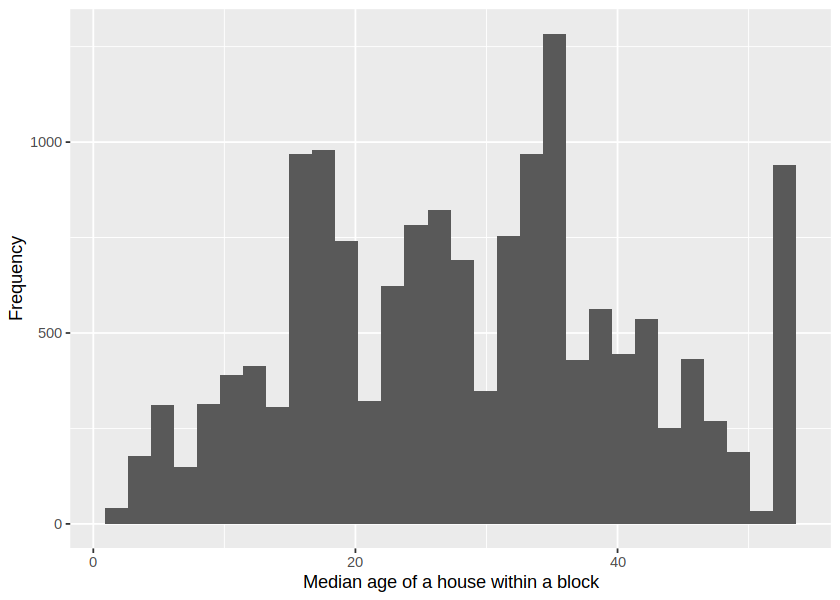

In [8]:
#compares the distributions of each of the predictor variables
options(repr.plot.width = 7, repr.plot.height = 5)
print(
    ggplot(housing_train, aes(housing_median_age)) + 
        geom_histogram(bins = 30) + 
        labs(x = "Median age of a house within a block",y = "Frequency")
)

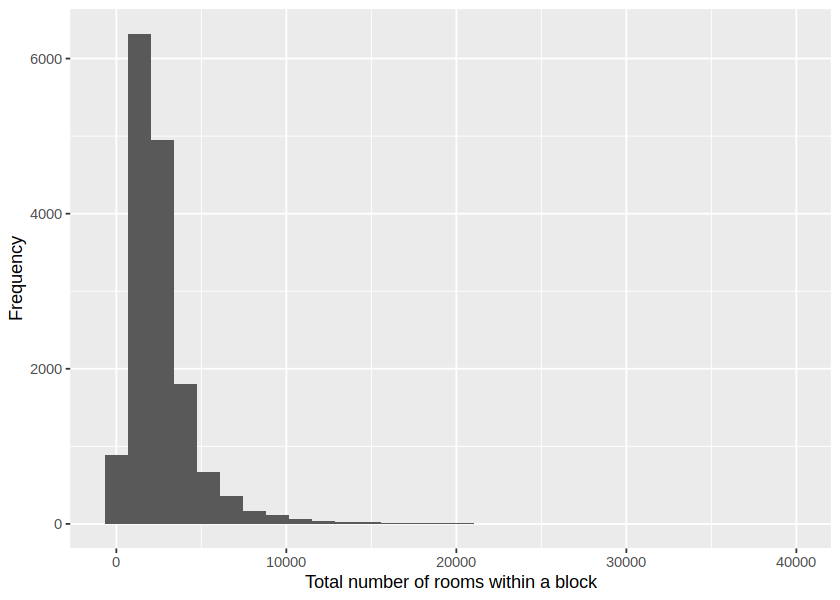

In [9]:
options(repr.plot.width = 7, repr.plot.height = 5)
print(
    ggplot(housing_train, aes(total_rooms)) + 
        geom_histogram(bins = 30) + 
        labs(x = "Total number of rooms within a block",y = "Frequency")
)

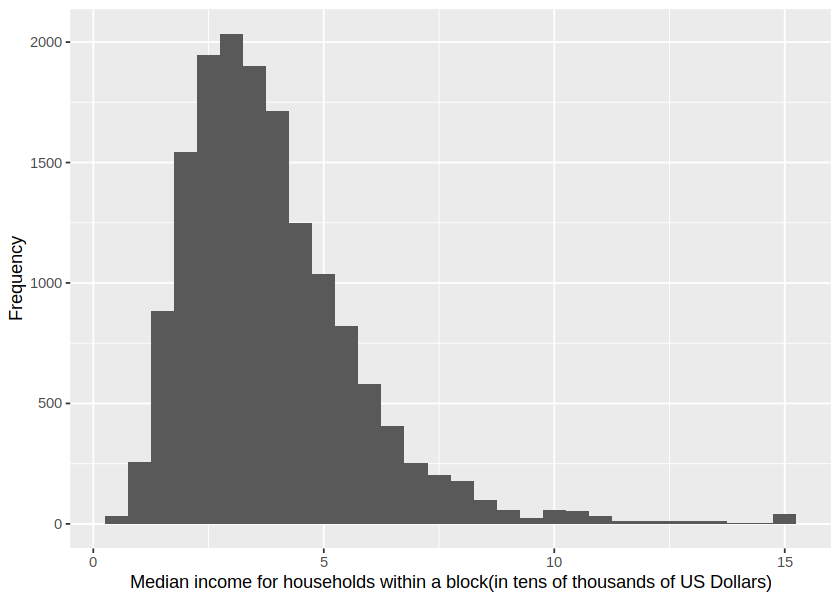

In [10]:
options(repr.plot.width = 7, repr.plot.height = 5)
print(
    ggplot(housing_train, aes(median_income)) + 
        geom_histogram(bins = 30) + 
        labs(x = "Median income for households within a block(in tens of thousands of US Dollars)",y = "Frequency")
)

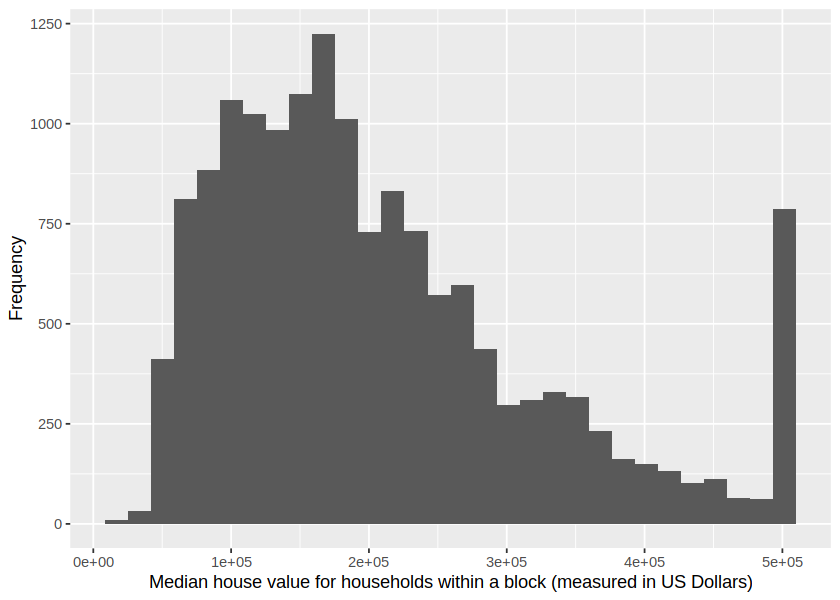

In [11]:
options(repr.plot.width = 7, repr.plot.height = 5)
print(
    ggplot(housing_train, aes(median_house_value)) + 
        geom_histogram(bins = 30) + 
        labs(x = "Median house value for households within a block (measured in US Dollars)",y = "Frequency")
)

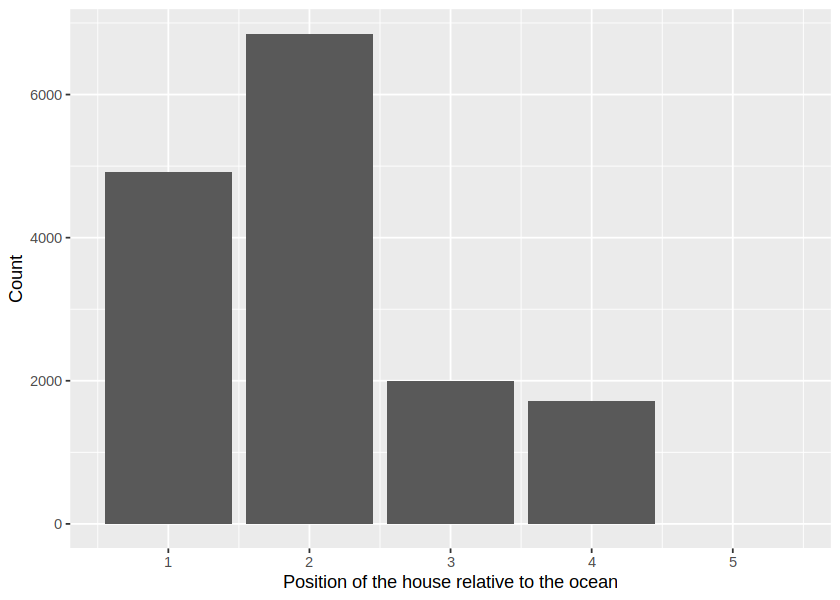

In [12]:
options(repr.plot.width = 7, repr.plot.height = 5)
print(ggplot(housing_train,aes(x=ocean_proximity_numeric)) + 
    geom_bar() + 
    labs(x = "Position of the house relative to the ocean",y = "Count"))

In [14]:
options(repr.plot.width = 8, repr.plot.height = 8)
# your code here
housing_pairs <- housing_train  |>
     ggpairs(aes(alpha = 0.05)) +
     theme(text = element_text(size = 20))
housing_pairs

ERROR: Error in ggpairs(housing_train, aes(alpha = 0.05)): could not find function "ggpairs"


In [13]:
#scaled the data
housing_recipe <- recipe(median_house_value ~., data = housing_train) |>
                       step_scale(all_predictors()) |>
                       step_center(all_predictors())

housing_scaled <- housing_recipe |>  
                           prep() |> 
                           bake(housing_train)

In [15]:
housing_scaled

housing_median_age,total_rooms,median_income,ocean_proximity_numeric,median_house_value
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.3873057,-0.6216278,0.6597315,-1.095243,315600
-0.8395808,2.1704033,1.3728275,-1.095243,323000
-0.4419225,-0.1861859,1.8102994,-1.095243,337200
⋮,⋮,⋮,⋮,⋮
-0.6805175,0.3031156,1.0049439,2.082701,297600
-1.1577075,0.4975581,-0.6915194,2.082701,208000
-1.6348974,1.1183138,-0.1684528,2.082701,213200
